# Importing libraries and dataset

Dataset shape: (920, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None
Missing values per column:
 id            0
age           0
sex           0
dataset       0
cp     

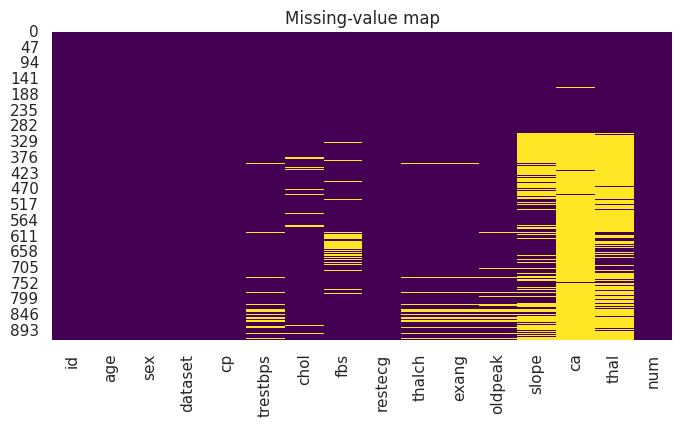

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer   # noqa
from sklearn.impute import IterativeImputer, SimpleImputer

from google.colab import files

from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold,
    cross_val_score, learning_curve
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, PolynomialFeatures
)
from sklearn.linear_model import (
    LinearRegression, LogisticRegression
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

sns.set(style="whitegrid")

df = pd.read_csv('heart_disease_uci.csv')
print("Dataset shape:", df.shape)
df.head()


# 2. Initial info & target distribution
print(df.info())
print("Missing values per column:\n", df.isnull().sum())
print("Target distribution (num):\n", df['num'].value_counts())


# 3. Initial EDA & simple plots

# 3.1 Missing‐value heatmap
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing‐value map")
plt.show()

# Handling Missing data

In [7]:
#    Define which columns are numeric vs. categorical
#    Here I treat 'slope', 'ca', and 'thal' as categorical (discrete) even
#    though they are encoded as numbers.
numeric_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# 4. Set up the imputers
# 4.1 Continuous: IterativeImputer (a.k.a. Multivariate Imputer)
num_imputer = IterativeImputer(
    random_state=42,
    max_iter=10,
    initial_strategy='median'   # use median for the first guess
)

# 4.2 Categorical: fill with the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')

# 5. Fit & transform each group of columns
# 5.1 Continuous features
df_num = df[numeric_cols]
df_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(df_num),
    columns=numeric_cols,
    index=df.index
)

# 5.2 Categorical features
df_cat = df[categorical_cols]
df_cat_imputed = pd.DataFrame(
    cat_imputer.fit_transform(df_cat),
    columns=categorical_cols,
    index=df.index
)

# 6. Merge imputed columns back into a single DataFrame
df_filled = df.copy()
df_filled[numeric_cols] = df_num_imputed
df_filled[categorical_cols] = df_cat_imputed

# 7. Verify there are no more missing values
print("After imputation, missing counts:", df_filled.isnull().sum())

After imputation, missing counts: id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


# correlated features andd spliting the data into classification and regression

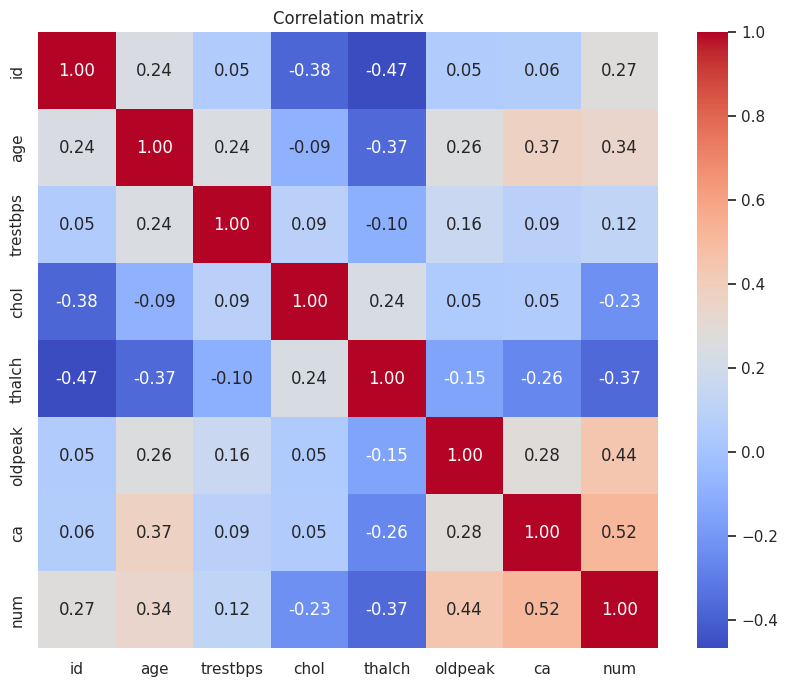

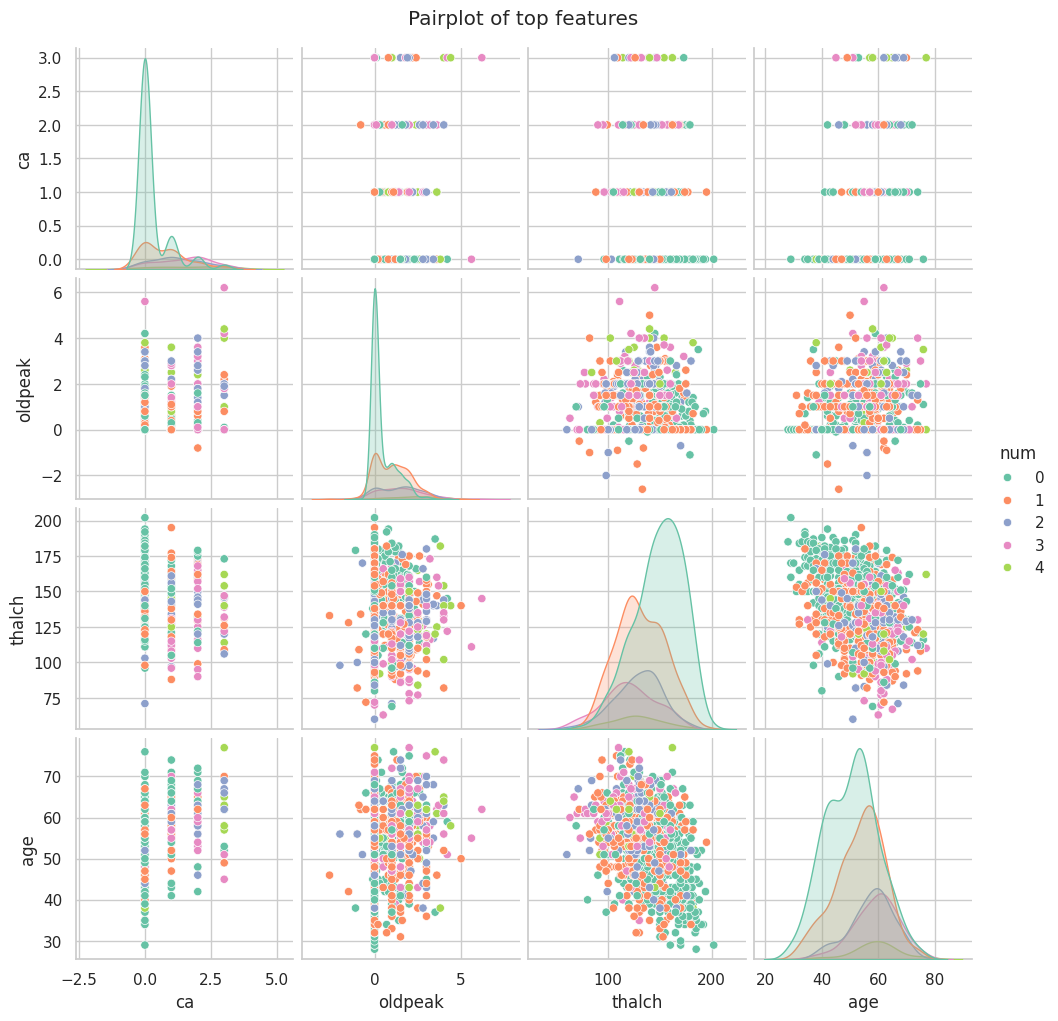

Numeric cols: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [8]:
# 3.2 Correlation heatmap (numeric features)
num_feats = df.select_dtypes(include=[np.number]).columns
corr = df[num_feats].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# 3.3 Pairplot of top 4 features most correlated with 'num'
top4 = corr['num'].abs().sort_values(ascending=False).index[1:5]
sns.pairplot(df, vars=top4, hue='num', palette='Set2')
plt.suptitle("Pairplot of top features", y=1.02)
plt.show()


# 4. Prepare X & y for regression and classification
X = df.drop('num', axis=1)
y_reg = df['num']                           # 0–4 heart disease severity
y_clf = (df['num'] > 0).astype(int)          # binary: 0=healthy,1=diseased


# 5. Auto‐detect numeric vs categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Coerce bad entries in numeric → NaN
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce')


# 6. Train/Test split
# Regression split (no stratify)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X, y_reg, test_size=0.30, random_state=42
)
# Classification split (stratify on y_clf)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y_clf, test_size=0.30, random_state=42, stratify=y_clf
)

# Imputing, Scaling and Encoding the data

In [9]:
# 7. Build preprocessors

# 7.1 Imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_imputer.fit(Xr_train[num_cols])
cat_imputer.fit(Xr_train[cat_cols])

# 7.2 Compute IQR clipping bounds on train numerics
Xr_num_imp = pd.DataFrame(
    num_imputer.transform(Xr_train[num_cols]),
    columns=num_cols
)
Q1 = Xr_num_imp.quantile(0.25)
Q3 = Xr_num_imp.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 7.3 Scaler
scaler = StandardScaler()
Xr_num_clip = Xr_num_imp.clip(lower_bound, upper_bound, axis=1)
scaler.fit(Xr_num_clip)

# 7.4 One‐hot encoder
ohe = OneHotEncoder(sparse_output=False, drop='first')
Xr_cat_imp = pd.DataFrame(
    cat_imputer.transform(Xr_train[cat_cols]),
    columns=cat_cols
)
ohe.fit(Xr_cat_imp)


OneHotEncoder(drop='first', sparse_output=False)

# Applying preprocessing

In [10]:
# 8. Preprocess function
def preprocess(dfX):
    # numeric: impute → clip → scale
    Xn = pd.DataFrame(
        num_imputer.transform(dfX[num_cols]),
        columns=num_cols
    ).clip(lower_bound, upper_bound, axis=1)
    Xn = scaler.transform(Xn)
    # categorical: impute → OHE
    Xc = pd.DataFrame(
        cat_imputer.transform(dfX[cat_cols]),
        columns=cat_cols
    )
    Xc = ohe.transform(Xc)
    # concatenate
    return np.hstack([Xn, Xc])

# Apply to all sets
Xr_tr = preprocess(Xr_train)
Xr_te = preprocess(Xr_test)
Xc_tr = preprocess(Xc_train)
Xc_te = preprocess(Xc_test)

print("After preprocess shapes:", Xr_tr.shape, Xc_tr.shape)


After preprocess shapes: (644, 22) (644, 22)


# Visualizing the data after preprocessing


<ipython-input-11-8b0cf55f5059>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[num_cols].melt(var_name='feat', value_name='val'),
<ipython-input-11-8b0cf55f5059>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_num_after.melt(var_name='feat', value_name='val'),


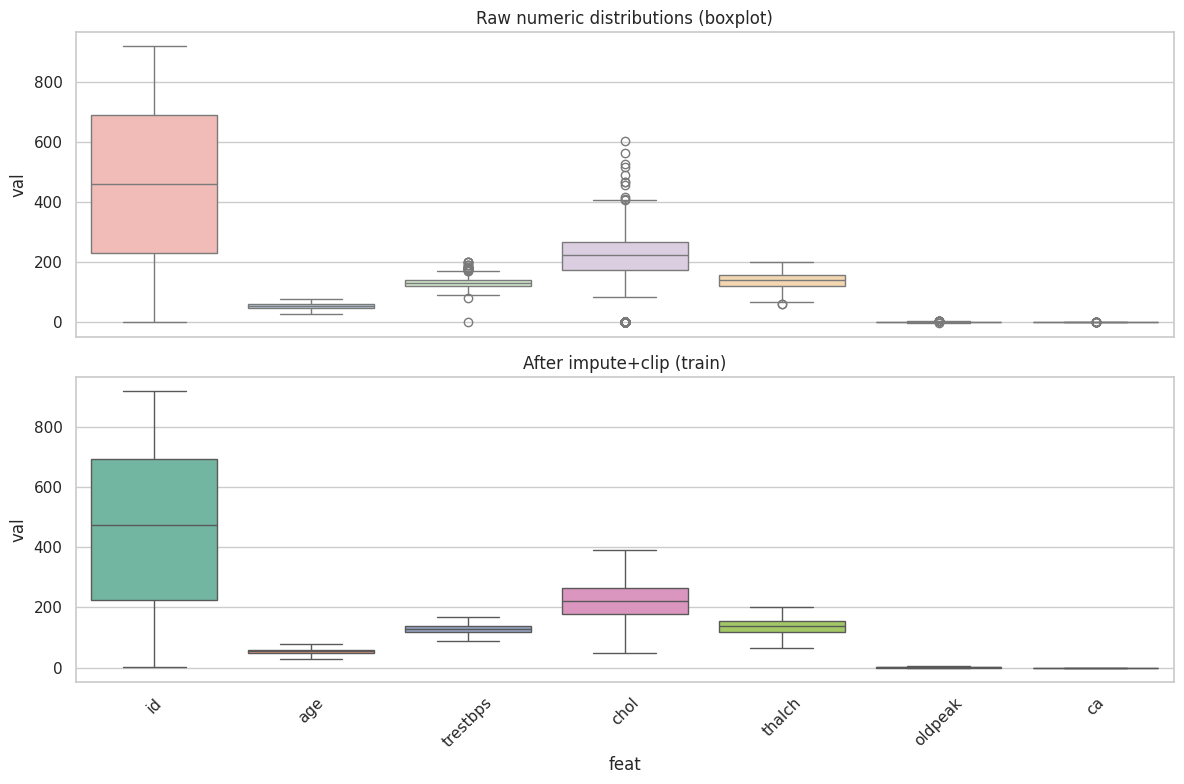

In [11]:
# 9. Preprocessing impact visualization

# 9.1 Boxplots before & after (all numeric)
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.boxplot(data=df[num_cols].melt(var_name='feat', value_name='val'),
            x='feat', y='val', ax=axes[0], palette='Pastel1')
axes[0].set_title("Raw numeric distributions (boxplot)")
axes[0].tick_params(axis='x', rotation=45)

df_num_after = pd.DataFrame(
    num_imputer.transform(Xr_train[num_cols]),
    columns=num_cols
).clip(lower_bound, upper_bound, axis=1)
sns.boxplot(data=df_num_after.melt(var_name='feat', value_name='val'),
            x='feat', y='val', ax=axes[1], palette='Set2')
axes[1].set_title("After impute+clip (train)")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


# Defining ML models

In [12]:
# 10. Define models

# 10.1 Regression models
reg_models = {
    'LinReg'      : LinearRegression(),
    'PolyReg(d=3)': LinearRegression(),
    'KNNReg'      : KNeighborsRegressor(),
    'SVR'         : SVR(kernel='rbf'),
    'DTReg'       : DecisionTreeRegressor(random_state=42),
    'RFReg'       : RandomForestRegressor(n_estimators=50, random_state=42)
}

# 10.2 Classification models
clf_models = {
    'LogReg' : LogisticRegression(max_iter=1000, random_state=42),
    'NB'     : GaussianNB(),
    'SVC'    : SVC(kernel='rbf', probability=True, random_state=42),
    'DTClf'  : DecisionTreeClassifier(random_state=42),
    'RFClf'  : RandomForestClassifier(n_estimators=50, random_state=42)
}


# Cross-Validation


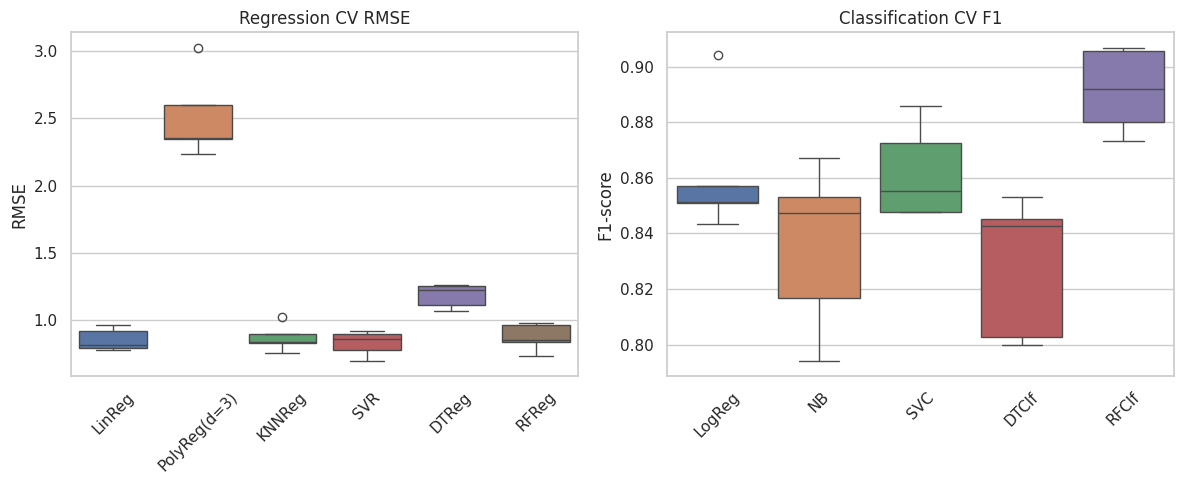

In [13]:
# 11. Cross‐validation on train

kf  = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 11.1 Regression CV (RMSE)
reg_cv = {}
for name, m in reg_models.items():
    if name.startswith('PolyReg'):
        # wrap poly inside CV
        pf = PolynomialFeatures(degree=3, include_bias=False)
        Xp = pf.fit_transform(Xr_tr)
        scores = cross_val_score(
            LinearRegression(), Xp, yr_train,
            cv=kf, scoring='neg_root_mean_squared_error'
        )
    else:
        scores = cross_val_score(
            m, Xr_tr, yr_train,
            cv=kf, scoring='neg_root_mean_squared_error'
        )
    reg_cv[name] = -scores

# 11.2 Classification CV (F1)
clf_cv = {}
for name, m in clf_models.items():
    scores = cross_val_score(
        m, Xc_tr, yc_train,
        cv=skf, scoring='f1'
    )
    clf_cv[name] = scores

# 11.3 Plot CV distributions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=pd.DataFrame(reg_cv))
plt.xticks(rotation=45); plt.ylabel("RMSE")
plt.title("Regression CV RMSE")

plt.subplot(1,2,2)
sns.boxplot(data=pd.DataFrame(clf_cv))
plt.xticks(rotation=45); plt.ylabel("F1-score")
plt.title("Classification CV F1")
plt.tight_layout()
plt.show()


# Visualizing regression methods


=== Regression Test Results ===
LinReg          | RMSE=0.872 | R²=0.433


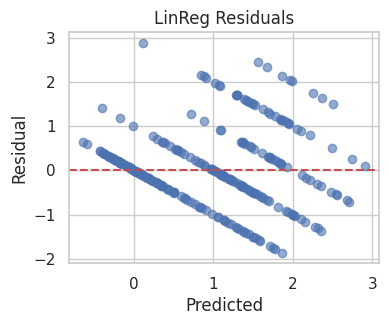

PolyReg(d=3)    | RMSE=3.704 | R²=-9.243


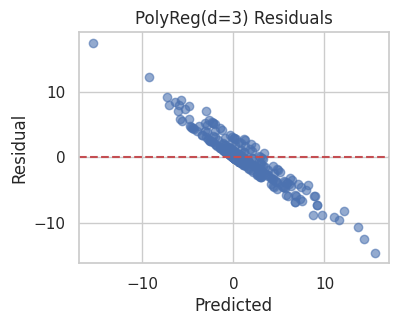

KNNReg          | RMSE=0.886 | R²=0.414


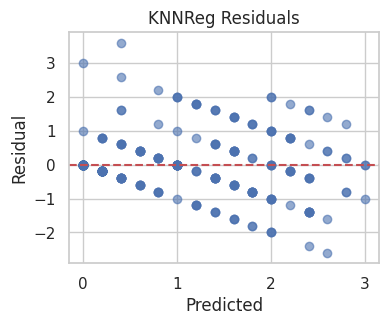

SVR             | RMSE=0.870 | R²=0.434


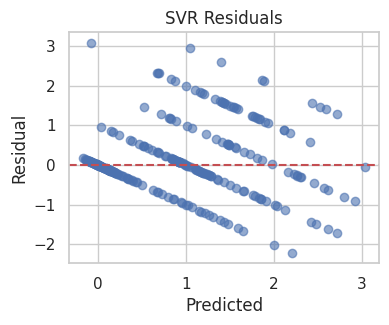

DTReg           | RMSE=1.186 | R²=-0.050


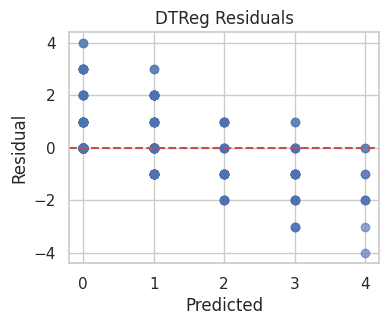

RFReg           | RMSE=0.846 | R²=0.466


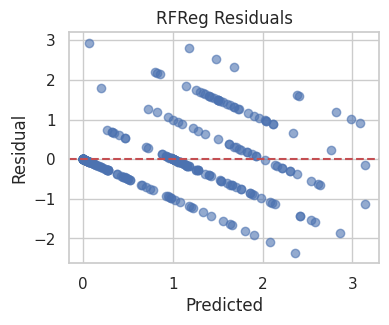

In [14]:
# 12.1 Regression final
print("=== Regression Test Results ===")
for name, m in reg_models.items():
    if name.startswith('PolyReg'):
        pf = PolynomialFeatures(degree=3, include_bias=False)
        Xp_tr = pf.fit_transform(Xr_tr)
        Xp_te = pf.transform(Xr_te)
        m.fit(Xp_tr, yr_train)
        yp = m.predict(Xp_te)
    else:
        m.fit(Xr_tr, yr_train)
        yp = m.predict(Xr_te)
    rmse = np.sqrt(mean_squared_error(yr_test, yp))
    r2   = r2_score(yr_test, yp)
    print(f"{name:15s} | RMSE={rmse:.3f} | R²={r2:.3f}")
    # residual plot
    resid = yr_test - yp
    plt.figure(figsize=(4,3))
    plt.scatter(yp, resid, alpha=0.6)
    plt.axhline(0, color='r', ls='--')
    plt.xlabel("Predicted"); plt.ylabel("Residual")
    plt.title(f"{name} Residuals")
    plt.show()


# Visualizing Classification methods


=== Classification Test Results ===
LogReg  | Acc=0.837 | Prec=0.846 | Rec=0.863 | F1=0.854


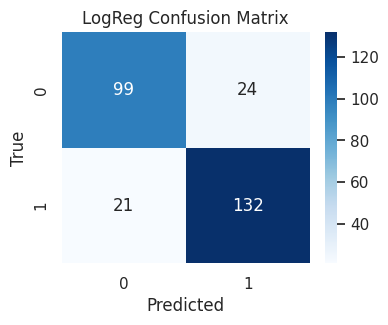

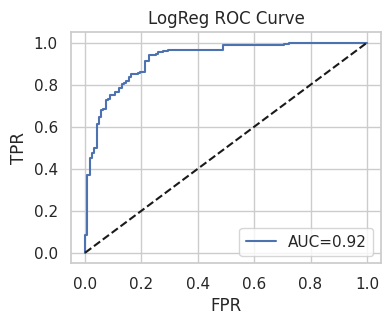

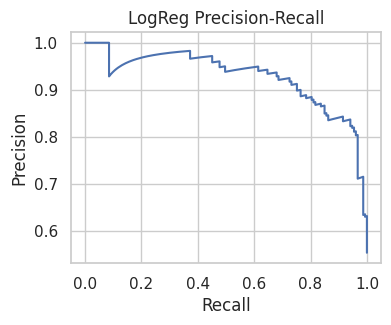

NB      | Acc=0.812 | Prec=0.858 | Rec=0.791 | F1=0.823


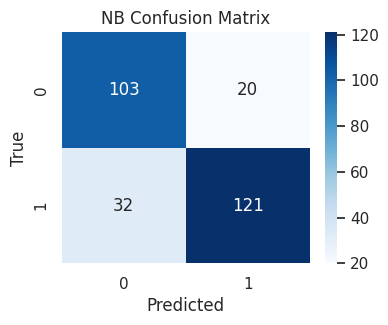

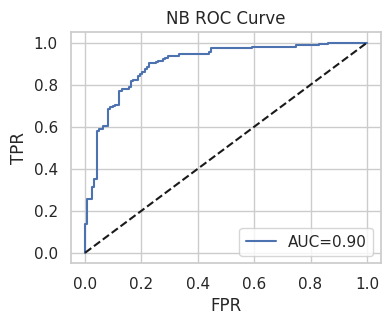

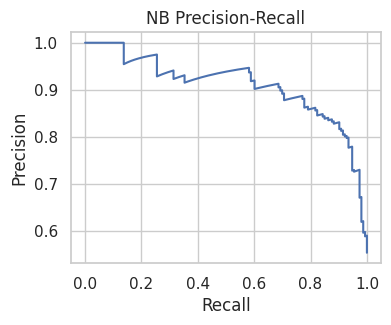

SVC     | Acc=0.841 | Prec=0.843 | Rec=0.876 | F1=0.859


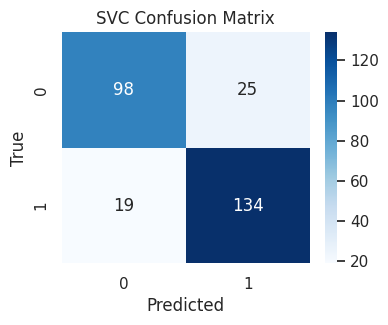

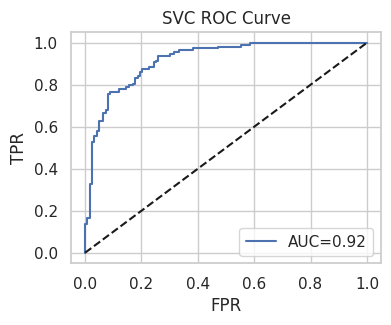

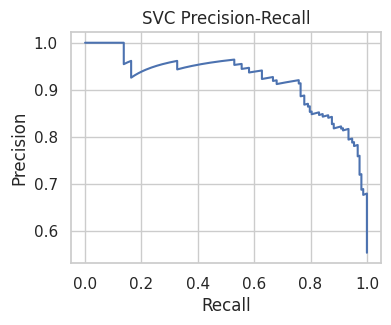

DTClf   | Acc=0.819 | Prec=0.824 | Rec=0.856 | F1=0.840


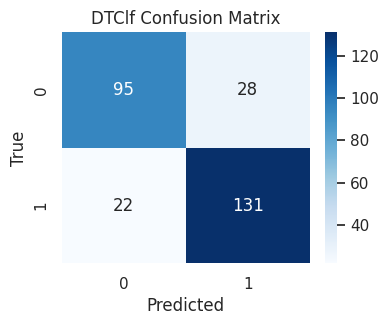

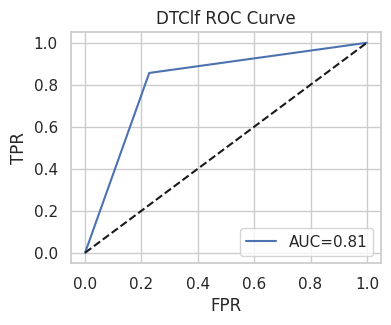

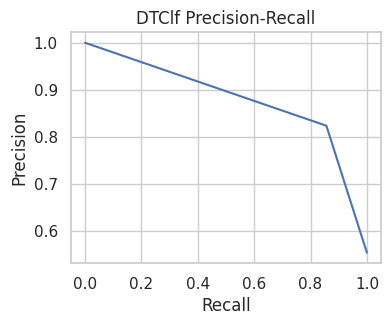

RFClf   | Acc=0.877 | Prec=0.879 | Rec=0.902 | F1=0.890


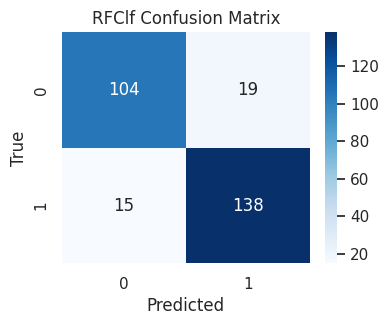

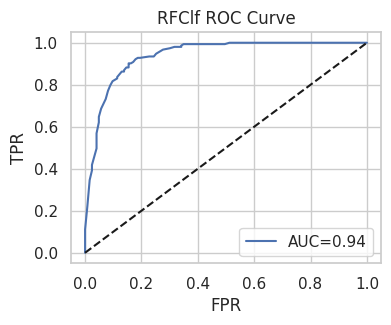

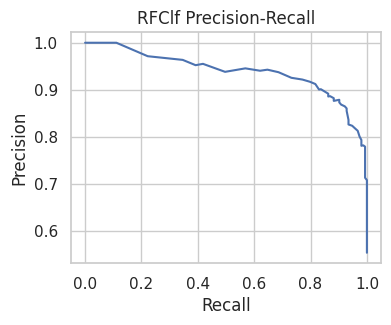

In [24]:
# 12.2 Classification final
print("\n=== Classification Test Results ===")
for name, m in clf_models.items():
    m.fit(Xc_tr, yc_train)
    yp = m.predict(Xc_te)
    probs = m.predict_proba(Xc_te)[:,1] if hasattr(m, "predict_proba") else None

    acc  = accuracy_score(yc_test, yp)
    prec = precision_score(yc_test, yp)
    rec  = recall_score(yc_test, yp)
    f1   = f1_score(yc_test, yp)
    print(f"{name:7s} | Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f}")

    # confusion matrix
    cm = confusion_matrix(yc_test, yp)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # ROC & PR curves (if probabilities available)
    if probs is not None:
        fpr, tpr, _ = roc_curve(yc_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4,3))
        plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
        plt.plot([0,1],[0,1],'k--')
        plt.title(f"{name} ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(); plt.show()

        precs, recs, _ = precision_recall_curve(yc_test, probs)
        plt.figure(figsize=(4,3))
        plt.plot(recs, precs)
        plt.title(f"{name} Precision‐Recall"); plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.show()



# Applying one hidden layer neural nework

In [26]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore only convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# 13. MLP & sensitivity analysis

# 13.1 Single MLP fit & metrics
mlp_reg = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
mlp_reg.fit(Xr_tr, yr_train)
ypr = mlp_reg.predict(Xr_te)
print("MLPReg | RMSE =", np.sqrt(mean_squared_error(yr_test, ypr)),
      "| R²=", r2_score(yr_test, ypr))

mlp_clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
mlp_clf.fit(Xc_tr, yc_train)
ypc = mlp_clf.predict(Xc_te)
print("MLPClf | Acc =", accuracy_score(yc_test, ypc),
      "| F1 =", f1_score(yc_test, ypc))

# 13.2 MLP architecture sensitivity
configs = [(10,), (20,), (50,), (20,10), (50,20)]
sens = []
Xc_all = np.vstack([Xc_tr, Xc_te])
yc_all = np.hstack([yc_train, yc_test])
for cfg in configs:
    clf = MLPClassifier(hidden_layer_sizes=cfg, max_iter=500, random_state=42)
    scores = cross_val_score(clf, Xc_all, yc_all, cv=5, scoring='f1')
    sens.append((str(cfg), scores.mean(), scores.std()))



MLPReg | RMSE = 0.9167687064818396 | R²= 0.37244411619700324
MLPClf | Acc = 0.855072463768116 | F1 = 0.8709677419354839


# Visualizing different neurons impact on data

     config   F1_mean    F1_std
0     (10,)  0.859783  0.009510
1     (20,)  0.850964  0.016638
2     (50,)  0.858888  0.025623
3  (20, 10)  0.828630  0.024462
4  (50, 20)  0.849492  0.026413


<ipython-input-27-7ff24a31a128>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
<ipython-input-27-7ff24a31a128>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


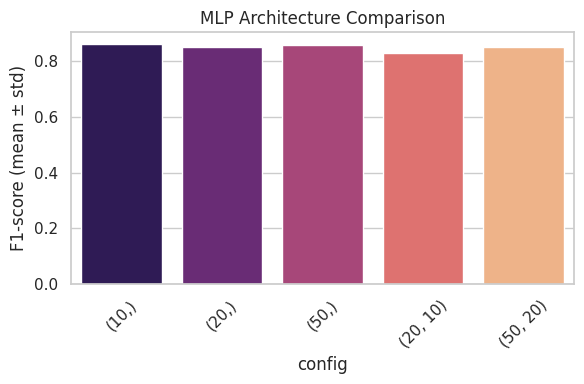

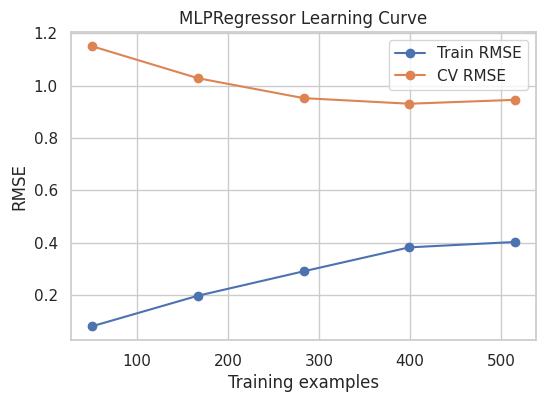

In [27]:
sens_df = pd.DataFrame(sens, columns=['config','F1_mean','F1_std'])
print(sens_df)

plt.figure(figsize=(6,4))
sns.barplot(
    x='config',
    y='F1_mean',
    data=sens_df,
    palette='magma',
    ci="sd",      # draw ±1×std from the data
    capsize=0.2
)
plt.xticks(rotation=45)
plt.ylabel("F1-score (mean ± std)")
plt.title("MLP Architecture Comparison")
plt.tight_layout()
plt.show()

# 13.3 Learning curve for MLPRegressor
train_sizes, train_scores, val_scores = learning_curve(
    MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    Xr_tr, yr_train, cv=5,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1
)
train_rmse = -train_scores.mean(axis=1)
val_rmse   = -val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, 'o-', label="Train RMSE")
plt.plot(train_sizes, val_rmse,   'o-', label="CV RMSE")
plt.xlabel("Training examples"); plt.ylabel("RMSE")
plt.legend(); plt.title("MLPRegressor Learning Curve")
plt.show()

